# Drug Screening Pipeline
## Pharmacophore-Based Virtual Screening with Interactive Tools

[![Python](https://img.shields.io/badge/Python-3.9+-blue.svg)](https://python.org)
[![RDKit](https://img.shields.io/badge/RDKit-2023+-orange.svg)](https://rdkit.org)
[![py3Dmol](https://img.shields.io/badge/py3Dmol-Interactive_3D-green.svg)](https://github.com/3dmol/3Dmol.js)

---

## 🎯 Project Overview

This notebook implements a **complete virtual drug screening pipeline** that combines multiple computational chemistry approaches to identify potential drug candidates. The workflow mimics real-world pharmaceutical research by:

1. **Filtering molecules** based on drug-likeness rules (Lipinski, Veber, Lead-like)
2. **Computing molecular similarities** using multiple fingerprint types
3. **Analyzing 3D pharmacophore features** for binding site compatibility
4. **Ranking candidates** using consensus scoring

### Why This Approach?

| Method | What It Measures | Drug Discovery Value |
|--------|-----------------|---------------------|
| **Morgan/ECFP** | 2D substructure similarity | Chemical series identification |
| **2D Pharmacophore** | Functional group patterns | Bioisostere discovery |
| **3D Pharmacophore** | Spatial feature arrangement | Binding mode prediction |
| **Consensus** | Multi-metric agreement | Reduced false positives |

### Pipeline Architecture

```
┌─────────────────────────────────────────────────────────────────┐
│                    INPUT: SMILES Dataset                        │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│               STEP 1: Data Loading & Preparation                │
│   • RDKit molecule parsing                                      │
│   • DrugMolecule object creation                                │
│   • Descriptor calculation (MW, LogP, TPSA, QED, etc.)          │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│               STEP 2: Drug-likeness Filtering                   │
│   • Lipinski's Rule of 5 (oral bioavailability)                 │
│   • Veber's Rules (intestinal absorption)                       │
│   • Lead-like criteria (early-stage optimization)               │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│               STEP 3: Similarity Analysis                       │
│   • Morgan/ECFP fingerprints (2048-bit)                         │
│   • 2D Pharmacophore fingerprints (Gobbi-Pharm2D)               │
│   • 3D Pharmacophore fingerprints (distance-binned)             │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│               STEP 4: Consensus Scoring & Ranking               │
│   • Reference drug comparison (e.g., Ibuprofen)                 │
│   • Weighted consensus: Morgan + Pharm2D + Pharm3D              │
│   • Final candidate prioritization                              │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│               STEP 5: Interactive Visualization                 │
│   • 3D molecular viewer (py3Dmol)                               │
│   • Pharmacophore feature mapping                               │
│   • Similarity heatmaps                                         │
│   • Drug discovery dashboard                                    │
└─────────────────────────────────────────────────────────────────┘
```

---

## Key Concepts

### Pharmacophore Model
A **pharmacophore** is the 3D arrangement of chemical features necessary for biological activity:

| Feature | Symbol | Chemical Groups | Role in Binding |
|---------|--------|-----------------|-----------------|
| **H-Bond Donor** | D | -OH, -NH₂, -NH | Donates proton to acceptor in protein |
| **H-Bond Acceptor** | A | C=O, -O-, -N< | Accepts proton from donor in protein |
| **Aromatic** | Ar | Benzene, heteroaromatics | π-stacking with Phe, Tyr, Trp |
| **Hydrophobe** | H | Alkyl, halogen | Van der Waals with hydrophobic pocket |
| **Positive Ionizable** | P | -NH₃⁺, guanidinium | Salt bridge with Asp, Glu |
| **Negative Ionizable** | N | -COO⁻, -SO₃⁻ | Salt bridge with Arg, Lys |

### Tanimoto Similarity
The standard metric for comparing molecular fingerprints:

$$T(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{c}{a + b - c}$$

Where $a$ = bits set in A, $b$ = bits set in B, $c$ = bits set in both.

---
## 📦 Step 1: Setup and Data Loading

### What This Cell Does

Imports all required libraries and initializes the pharmacophore feature factory. The libraries are organized into:

| Category | Libraries | Purpose |
|----------|-----------|---------|
| **Data Science** | pandas, numpy | Data manipulation |
| **Cheminformatics** | RDKit (Chem, AllChem, Descriptors) | Molecular processing |
| **Pharmacophore** | Gobbi_Pharm2D, ChemicalFeatures | Feature detection |
| **Visualization** | matplotlib, seaborn, py3Dmol | 2D/3D plotting |
| **Interactive** | ipywidgets | GUI components |
| **Custom Modules** | src.core, src.interactive | Project-specific tools |

### Pharmacophore Feature Factory

The `FEATURE_FACTORY` loads RDKit's `BaseFeatures.fdef` file, which defines SMARTS patterns for detecting pharmacophore features in molecules. This is the foundation for all pharmacophore-based analyses.

In [1]:
 # Core imports
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# RDKit imports
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdMolAlign, rdShapeHelpers, Draw, Descriptors
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import py3Dmol
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML, Image

# src package imports
from src.core.molecule import DrugMolecule
from src.interactive import (
    InteractivePropertyFilter,
    InteractivePy3DmolViewer,
    MolecularEditor
)

# Clustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import defaultdict

# Pharmacophore setup
fdefName = Path(RDConfig.RDDataDir) / 'BaseFeatures.fdef'
FEATURE_FACTORY = ChemicalFeatures.BuildFeatureFactory(str(fdefName))

PHARM_COLORS = {
    'Donor': '0x3498db', 'Acceptor': '0xe74c3c', 'Aromatic': '0x9b59b6',
    'Hydrophobe': '0x2ecc71', 'LumpedHydrophobe': '0x27ae60',
    'PosIonizable': '0xf39c12', 'NegIonizable': '0xe67e22'
}

print("✅ All libraries loaded successfully!")
print(f"📦 RDKit Version: {Chem.rdBase.rdkitVersion}")


✅ All libraries loaded successfully!
📦 RDKit Version: 2022.09.5


### 1b: Load Molecular Dataset

This cell:
1. **Loads the CSV** containing SMILES strings and DFT-computed properties
2. **Parses SMILES** into RDKit molecule objects
3. **Creates DrugMolecule objects** with calculated descriptors (MW, LogP, TPSA, QED, etc.)

The `DrugMolecule` class encapsulates:
- Molecular structure (RDKit mol object)
- Calculated properties dictionary
- Helper methods for filtering and comparison

In [2]:
# Load molecular dataset
df = pd.read_csv('datasets/final-185_dft_analysis_results.csv')
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)
df = df[df['mol'].notna()].reset_index(drop=True)

print(f"✅ Loaded {len(df)} molecules from dataset")
print(f"\n📊 Sample molecules:")
for i, name in enumerate(df['Molecule_Name'].head(5)):
    print(f"   {i+1}. {name.replace('_optimized', '')}")


# Convert to DrugMolecule objects
print("🔄 Converting to DrugMolecule objects...")

drug_molecules = []
for _, row in df.iterrows():
    try:
        mol = DrugMolecule(
            name=row['Molecule_Name'].replace('_optimized', ''),
            cas='',
            smiles=row['SMILES']
        )
        mol.calculate_descriptors()
        drug_molecules.append(mol)
    except Exception as e:
        pass  # Skip problematic molecules

print(f"✅ Converted {len(drug_molecules)} molecules")

✅ Loaded 166 molecules from dataset

📊 Sample molecules:
   1. Midazolam
   2. Metformin
   3. Empagliflozin
   4. Valacyclovir
   5. Fluoxetine
🔄 Converting to DrugMolecule objects...
✅ Converted 166 molecules


---
## 🔬 Step 2: Drug-Likeness Filtering

### Interactive Property Filter

The `InteractivePropertyFilter` widget allows real-time filtering based on **three rule sets**:

#### Lipinski's Rule of Five (1997)
Predicts oral bioavailability. A molecule is "drug-like" if it satisfies at least 4 of:
- **MW ≤ 500** — Small enough for absorption
- **LogP ≤ 5** — Not too hydrophobic
- **HBD ≤ 5** — H-bond donors
- **HBA ≤ 10** — H-bond acceptors

#### Veber's Rules (2002)
Predicts intestinal permeability:
- **Rotatable Bonds ≤ 10** — Molecular flexibility
- **TPSA ≤ 140 Å²** — Polar surface area

#### Lead-like Criteria (Teague, 1999)
More stringent for early-stage drug discovery:
- **MW ≤ 450**
- **LogP ≤ 4.5**
- **Rotatable Bonds ≤ 7**

### QED Score
The **Quantitative Estimate of Drug-likeness** (Bickerton et al., 2012) combines 8 molecular properties into a single score [0-1]:

$$QED = \exp\left(\frac{1}{n}\sum_{i=1}^{n} \ln d_i\right)$$

Where $d_i$ are desirability functions for MW, LogP, HBA, HBD, TPSA, RotBonds, Rings, and Alerts.

In [3]:
# Create and display the interactive property filter
property_filter = InteractivePropertyFilter(drug_molecules)
display(property_filter.display())

### 2b: Apply Filter and Retrieve Results

After adjusting the sliders in the interactive widget above, this cell retrieves the filtered molecules. The filter applies:
- Property range constraints (MW, LogP, TPSA)
- Rule compliance checks (Lipinski, Veber, Lead-like)
- QED threshold filtering

The output shows key properties for each passing molecule.

In [4]:
# Get filtered molecules after adjusting sliders above
# ⚠️ Run this cell AFTER clicking 'Apply Filters' in the widget above

filtered_molecules = property_filter.get_filtered_molecules()

print(f"🎯 Retrieved {len(filtered_molecules)} filtered molecules")
print("\n📋 Filtered Molecules:")
print("=" * 60)

for i, mol in enumerate(filtered_molecules[:10], 1):
    props = mol.properties
    print(f"   {i:2d}. {mol.name}")
    print(f"       MW: {props.get('MW', 0):.1f} | LogP: {props.get('LogP', 0):.2f} | QED: {props.get('QED', 0):.3f}")

if len(filtered_molecules) > 10:
    print(f"\n   ... and {len(filtered_molecules) - 10} more molecules")

🎯 Retrieved 160 filtered molecules

📋 Filtered Molecules:
    1. Midazolam
       MW: 325.8 | LogP: 4.32 | QED: 0.655
    2. Metformin
       MW: 129.2 | LogP: -1.03 | QED: 0.249
    3. Empagliflozin
       MW: 448.9 | LogP: 2.77 | QED: 0.542
    4. Valacyclovir
       MW: 324.3 | LogP: -0.80 | QED: 0.442
    5. Fluoxetine
       MW: 309.3 | LogP: 4.44 | QED: 0.852
    6. Olanzapine
       MW: 312.4 | LogP: 3.44 | QED: 0.808
    7. Ciprofloxacin
       MW: 331.3 | LogP: 1.58 | QED: 0.893
    8. Itraconazole
       MW: 705.6 | LogP: 5.58 | QED: 0.174
    9. Tenofovir
       MW: 294.2 | LogP: -1.64 | QED: 0.461
   10. Omeprazole
       MW: 345.4 | LogP: 2.90 | QED: 0.769

   ... and 150 more molecules


---
## 🔮 3D Molecular Visualization

### Interactive py3Dmol Viewer

The `InteractivePy3DmolViewer` provides an interactive 3D molecular visualization powered by **3Dmol.js**. Features include:


In [5]:
# Create 3D viewer with filtered molecules
viewer_3d = InteractivePy3DmolViewer()
viewer_3d.load_molecules(filtered_molecules if filtered_molecules else drug_molecules)
display(viewer_3d.display())

---
### ✏️ Molecular Editor

The `MolecularEditor` widget enables interactive **lead optimization** by:
- Modifying functional groups
- Adding/removing substituents  
- Testing "what-if" modifications

This mimics the iterative design process in medicinal chemistry where small structural changes can dramatically affect activity.

In [6]:
# Create molecular editor
mol_editor = MolecularEditor(
    molecules_list=filtered_molecules if filtered_molecules else drug_molecules,
    drug_molecule_class=DrugMolecule
)
display(mol_editor.display())

---
## Step 3: Molecular Similarity Analysis

### Reference-Based Virtual Screening

This section computes similarity to a **reference drug** (Ibuprofen) using three complementary fingerprint methods:

### 3a: Load DFT-Optimized 3D Geometries

DFT (Density Functional Theory) provides **quantum mechanically optimized** 3D coordinates, which are more accurate than force-field generated conformations. These coordinates are essential for:
- Accurate 3D pharmacophore feature positioning
- Reliable shape-based similarity calculations
- Realistic binding pose predictions

The `create_mol_with_dft_coords()` function loads pre-computed DFT geometries from XYZ files.

In [7]:
from src.io import create_mol_with_dft_coords, load_xyz_coordinates

print("🔄 Loading DFT-optimized 3D geometries...")
df['mol_3d'] = [create_mol_with_dft_coords(row['SMILES'], row['Molecule_Name']) 
               for _, row in df.iterrows()]

print(f"✅ Loaded {df['mol_3d'].notna().sum()}/{len(df)} 3D structures")

🔄 Loading DFT-optimized 3D geometries...
✅ Loaded 166/166 3D structures


In [8]:
# Get Ibuprofen from the dataset
REFERENCE_DRUG = 'Ibuprofen_optimized'
ref_row = df[df['Molecule_Name'] == REFERENCE_DRUG].iloc[0]

### 3b: Compute Molecular Fingerprints

This cell computes **four types of molecular fingerprints**:

#### 1. Morgan/ECFP Fingerprints (2048-bit)
Extended Connectivity Fingerprints capture circular substructures:
- **Radius 2** = ECFP4 equivalent
- Encodes local atomic environments
- Good for chemical series identification

#### 2. 2D Pharmacophore Fingerprints (Gobbi-Pharm2D)
Encodes pharmacophore feature pairs and their topological distances:
- Uses SMARTS-based feature definitions
- Distance measured in bond counts
- Captures functional group arrangements

#### 3. 3D Pharmacophore Features
Extracts spatial positions of pharmacophore features:
- Uses DFT-optimized coordinates
- Outputs feature type + 3D coordinates
- Foundation for 3D similarity

#### 4. 3D Pharmacophore Fingerprints (Custom)
Distance-binned feature pairs in 3D space:

| Bin | Distance (Å) | Typical Interaction |
|-----|-------------|---------------------|
| 0 | 0-2 | Same atom/adjacent |
| 1 | 2-4 | H-bond distance |
| 2 | 4-6 | Short-range |
| 3 | 6-8 | Medium-range |
| 4 | 8-12 | Long-range |
| 5 | 12-20 | Extended |

The fingerprint key is `(FeatureType1, FeatureType2, DistanceBin)`.

### 3D Pharmacophore Pipeline Overview

```
┌──────────────────────────────────────────────────────────────┐
│                    3D MOLECULE                               │
│              (DFT-optimized coordinates)                     │
└──────────────────────────────────────────────────────────────┘
                           ↓
┌──────────────────────────────────────────────────────────────┐
│            3D PHARMACOPHORE FEATURES                         │
│  • Detect H-bond donors/acceptors, aromatics, etc.           │
│  • Output: List of (type, x, y, z) tuples                    │
│  • Example: [('Acceptor', 1.2, 3.4, 5.6), ...]              │
└──────────────────────────────────────────────────────────────┘
                           ↓
┌──────────────────────────────────────────────────────────────┐
│            3D PHARMACOPHORE FINGERPRINT                      │
│  • Encode pairwise feature distances into bins               │
│  • Output: Dictionary {(type1, type2, bin): count}           │
│  • Example: {('Donor', 'Acceptor', 2): 3}                   │
└──────────────────────────────────────────────────────────────┘
                           ↓
┌──────────────────────────────────────────────────────────────┐
│            3D PHARMACOPHORE SIMILARITY                       │
│  • Compare fingerprints using Tanimoto                       │
│  • Output: Single score [0.0 - 1.0]                          │
│  • Example: Mol_A vs Mol_B = 0.73                            │
└──────────────────────────────────────────────────────────────┘
```

In [9]:
from src.features import extract_pharm_features

print("🔄 Computing molecular fingerprints...")

# Morgan/ECFP fingerprints
df['morgan_fp'] = df['mol'].apply(
    lambda m: AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048) if m else None
)
print("   ✅ Morgan/ECFP fingerprints")

# 2D Pharmacophore fingerprints
df['pharm_fp_2d'] = df['mol'].apply(
    lambda m: Generate.Gen2DFingerprint(Chem.RemoveHs(m), Gobbi_Pharm2D.factory) if m else None
)
print("   ✅ 2D Pharmacophore fingerprints")

# Extract 3D pharmacophore features
df['pharm_features'] = df['mol_3d'].apply(extract_pharm_features)
df['n_features'] = df['pharm_features'].apply(len)
print("   ✅ 3D Pharmacophore features")

# 3D Pharmacophore fingerprint (binned distances)
DIST_BINS = [(0, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12, 20)]

def get_bin(d):
    for i, (lo, hi) in enumerate(DIST_BINS):
        if lo <= d < hi:
            return i
    return len(DIST_BINS) - 1

def compute_3d_fp(feats):
    if len(feats) < 2:
        return {}
    fp = defaultdict(int)
    for i in range(len(feats)):
        for j in range(i + 1, len(feats)):
            t1, t2 = feats[i]['type'], feats[j]['type']
            if t1 > t2:
                t1, t2 = t2, t1
            dist = np.linalg.norm(feats[i]['coords'] - feats[j]['coords'])
            fp[(t1, t2, get_bin(dist))] += 1
    return dict(fp)

df['pharm_fp_3d'] = df['pharm_features'].apply(compute_3d_fp)
print("   ✅ 3D Pharmacophore fingerprints")

print(f"\n✅ All fingerprints computed for {len(df)} molecules")

🔄 Computing molecular fingerprints...
   ✅ Morgan/ECFP fingerprints
   ✅ 2D Pharmacophore fingerprints
   ✅ 3D Pharmacophore features
   ✅ 3D Pharmacophore fingerprints

✅ All fingerprints computed for 166 molecules


### 3c: Compute Similarity Matrices

This cell builds **pairwise similarity matrices** for all molecules using **Tanimoto coefficient**:

$$T(A, B) = \frac{\sum_i \min(A_i, B_i)}{\sum_i \max(A_i, B_i)}$$

Three matrices are computed:
- `sim_morgan`: Chemical substructure similarity
- `sim_pharm_2d`: Topological pharmacophore similarity  
- `sim_pharm_3d`: Spatial pharmacophore similarity

Each matrix is an N×N symmetric matrix where entry (i,j) is the similarity between molecules i and j.

In [10]:
def compute_sim_matrix(fps, names):
    """Compute pairwise Tanimoto similarity matrix."""
    n = len(fps)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if fps[i] and fps[j]:
                mat[i, j] = mat[j, i] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
    return pd.DataFrame(mat, index=names, columns=names)

def tanimoto_dict(fp1, fp2):
    """Tanimoto similarity for dictionary-based fingerprints."""
    if not fp1 or not fp2:
        return 0.0
    keys = set(fp1) | set(fp2)
    intersection = sum(min(fp1.get(k, 0), fp2.get(k, 0)) for k in keys)
    union = sum(max(fp1.get(k, 0), fp2.get(k, 0)) for k in keys)
    return intersection / max(union, 1)

print("🔄 Computing similarity matrices...")

# Morgan similarity
sim_morgan = compute_sim_matrix(df['morgan_fp'].tolist(), df['Molecule_Name'].tolist())
print(f"   ✅ Morgan similarity: {sim_morgan.shape}")

# 2D Pharmacophore similarity
sim_pharm_2d = compute_sim_matrix(df['pharm_fp_2d'].tolist(), df['Molecule_Name'].tolist())
print(f"   ✅ 2D Pharmacophore similarity: {sim_pharm_2d.shape}")

# 3D Pharmacophore similarity
fps_3d = df['pharm_fp_3d'].tolist()
names = df['Molecule_Name'].tolist()
mat_3d = np.zeros((len(fps_3d), len(fps_3d)))
for i in range(len(fps_3d)):
    for j in range(i, len(fps_3d)):
        mat_3d[i, j] = mat_3d[j, i] = tanimoto_dict(fps_3d[i], fps_3d[j])
sim_pharm_3d = pd.DataFrame(mat_3d, index=names, columns=names)
print(f"   ✅ 3D Pharmacophore similarity: {sim_pharm_3d.shape}")

print(f"\n✅ All similarity matrices computed!")

🔄 Computing similarity matrices...
   ✅ Morgan similarity: (166, 166)
   ✅ 2D Pharmacophore similarity: (166, 166)
   ✅ 3D Pharmacophore similarity: (166, 166)

✅ All similarity matrices computed!


---
## Consensus Scoring

### Why Consensus?

No single similarity metric is perfect. By combining multiple orthogonal methods, we:
- **Reduce false positives** — Molecules must score well across all metrics
- **Capture different aspects** — Chemistry, topology, and 3D shape
- **Increase confidence** — High consensus = robust prediction

### Scoring Formula

$$\text{Consensus} = w_1 \cdot \text{Morgan} + w_2 \cdot \text{Pharm2D} + w_3 \cdot \text{Pharm3D}$$

Default weights: $w_1 = 0.4$, $w_2 = 0.3$, $w_3 = 0.3$

The weights can be adjusted based on the screening objective:
- **Lead hopping**: Increase Pharm3D weight (find structurally different but functionally similar molecules)
- **Me-too drugs**: Increase Morgan weight (find close analogs)
- **Scaffold hopping**: Increase Pharm2D weight (find topologically similar molecules)

In [11]:
# Create consensus scores
from src.similarity import compute_consensus_scores

consensus_df = compute_consensus_scores(REFERENCE_DRUG, sim_morgan, sim_pharm_2d, sim_pharm_3d)

print(f"Top 20 Consensus Hits for {REFERENCE_DRUG}")
print("=" * 80)
display(consensus_df.head(20).round(3).style.background_gradient(cmap='RdYlGn', subset=['Consensus']))

Top 20 Consensus Hits for Ibuprofen_optimized


,Molecule,Morgan,Pharm2D,Pharm3D,Consensus
91,Naproxen_optimized,0.421000,0.206000,0.626000,0.420000
163,Diclofenac_optimized,0.167000,0.148000,0.536000,0.286000
36,Carbamazepine_optimized,0.143000,0.102000,0.550000,0.268000
88,Ketorolac_optimized,0.137000,0.160000,0.486000,0.263000
134,Venlafaxine_optimized,0.176000,0.065000,0.479000,0.243000
111,Propofol_optimized,0.200000,0.000000,0.512000,0.240000
82,Escitalopram_optimized,0.184000,0.037000,0.482000,0.237000
153,Phenytoin_optimized,0.119000,0.073000,0.510000,0.237000
17,Warfarin_optimized,0.216000,0.045000,0.419000,0.228000
69,Gemfibrozil_optimized,0.148000,0.054000,0.446000,0.219000


---
### Update Filter with Similarity Scores

Now we **augment the property filter** with the computed similarity scores. This allows multi-criteria filtering:

| Filter Type | Examples |
|-------------|----------|
| **Property-based** | MW < 500, LogP < 5 |
| **Rule-based** | Lipinski pass, Veber pass |
| **Similarity-based** | Morgan > 0.5, Consensus > 0.6 |

The combination enables **tiered screening**:
1. Remove drug-likeness violators (property filter)
2. Remove dissimilar molecules (similarity filter)
3. Rank remaining by consensus score

---
## 🎛️ Step 4: Combined Filtering

### Filter 2: Similarity Score & Pharmacophore Thresholds

This interactive filter now includes:
- **Property sliders**: MW, LogP, TPSA, QED
- **Similarity sliders**: Morgan, Pharm2D, Pharm3D, Consensus
- **Rule toggles**: Lipinski, Veber, Lead-like

Adjust thresholds to find the optimal balance between **stringency** (fewer, higher-quality hits) and **coverage** (more hits, potentially more false positives).

In [12]:
# Update the InteractivePropertyFilter with computed similarity scores
property_filter.update_with_scores(
    consensus_df, 
    molecule_col='Molecule',
    score_cols=['Morgan', 'Pharm2D', 'Pharm3D', 'Consensus']
)

# Re-display the filter to see the updated interface
display(property_filter.display())

✅ Updated 165 molecules with similarity scores
   📊 Similarity columns now visible in table
   🎚️ Similarity sliders now active


### 4b: Create Final Candidate DataFrame (`passed_df`)

This cell:
1. Retrieves molecules passing all filter criteria
2. Maps similarity scores and rule compliance status
3. Sorts by consensus score (descending)
4. Creates `passed_df` — the final prioritized candidate list

The output shows top candidates with their:
- **Consensus score**: Overall similarity ranking
- **Rule compliance**: ✅/❌ for Lipinski, Veber, Lead-like

In [13]:
# Get molecules from the interactive filter
property_filter._apply_filters()
filtered = property_filter.get_filtered_molecules()

print(f"🎯 Found {len(filtered)} molecules matching all filter criteria")

# Get molecule names
filtered_names = [mol.name for mol in filtered]
filtered_names_with_suffix = [f"{name}_optimized" if not name.endswith('_optimized') else name for name in filtered_names]

# Create passed_df from original df
passed_df = df[df['Molecule_Name'].isin(filtered_names) | df['Molecule_Name'].isin(filtered_names_with_suffix)].copy()

# Create a dictionary with ALL properties for mapping
mol_props = {}
for mol in filtered:
    name = mol.name
    p = mol.properties
    
    # Calculate filter statuses
    lip_pass = (p.get('MW',0)<=500) and (p.get('LogP',0)<=5) and (p.get('HBD',0)<=5) and (p.get('HBA',0)<=10)
    veber_pass = (p.get('RotatableBonds',0)<=10) and (p.get('TPSA',0)<=140)
    lead_pass = (p.get('MW',0)<=450) and (p.get('LogP',0)<=4.5) and (p.get('RotatableBonds',0)<=7)
    
    mol_props[name] = {
        'Morgan': p.get('Morgan', 0),
        'Pharm2D': p.get('Pharm2D', 0),
        'Pharm3D': p.get('Pharm3D', 0),
        'Consensus': p.get('Consensus', 0),
        'QED': p.get('QED', 0),
        'MW': p.get('MW', 0),
        'LogP': p.get('LogP', 0),
        'TPSA': p.get('TPSA', 0),
        'Lipinski': '✅' if lip_pass else '❌',
        'Veber': '✅' if veber_pass else '❌',
        'Lead-like': '✅' if lead_pass else '❌'
    }
    mol_props[f"{name}_optimized"] = mol_props[name]

# Map properties to passed_df
cols_to_add = ['Morgan', 'Pharm2D', 'Pharm3D', 'Consensus', 'QED', 'MW', 'LogP', 'TPSA', 'Lipinski', 'Veber', 'Lead-like']
for col in cols_to_add:
    passed_df[col] = passed_df['Molecule_Name'].apply(lambda x: mol_props.get(x.replace('_optimized',''), {}).get(col))

# Add Molecule alias
passed_df['Molecule'] = passed_df['Molecule_Name'].str.replace('_optimized', '')

# Sort by Consensus
passed_df = passed_df.sort_values('Consensus', ascending=False).reset_index(drop=True)

print(f"\n📋 Created passed_df with {len(passed_df)} molecules")
print("\n🏆 Final Prioritized Candidates:")
print("=" * 80)
for rank, (_, row) in enumerate(passed_df.head(10).iterrows(), 1):
    print(f"   {rank}. {row['Molecule']}")
    print(f"       Consensus: {row['Consensus']:.3f} | Lipinski: {row['Lipinski']}")

🎯 Found 160 molecules matching all filter criteria

📋 Created passed_df with 160 molecules

🏆 Final Prioritized Candidates:
   1. Naproxen
       Consensus: 0.420 | Lipinski: ✅
   2. Diclofenac
       Consensus: 0.286 | Lipinski: ✅
   3. Carbamazepine
       Consensus: 0.268 | Lipinski: ✅
   4. Ketorolac
       Consensus: 0.263 | Lipinski: ✅
   5. Venlafaxine
       Consensus: 0.243 | Lipinski: ✅
   6. Propofol
       Consensus: 0.240 | Lipinski: ✅
   7. Escitalopram
       Consensus: 0.237 | Lipinski: ✅
   8. Phenytoin
       Consensus: 0.237 | Lipinski: ✅
   9. Warfarin
       Consensus: 0.228 | Lipinski: ✅
   10. Gemfibrozil
       Consensus: 0.219 | Lipinski: ✅


---
## 📊 Similarity Visualization

### Heatmap Analysis

This cell generates **side-by-side heatmaps** comparing:
- **Morgan/ECFP similarity** (left): Chemical substructure overlap
- **3D Pharmacophore similarity** (right): Spatial feature arrangement

### Interpreting the Heatmaps

| Pattern | Meaning | Implication |
|---------|---------|-------------|
| **Diagonal = 1.0** | Self-similarity | Expected behavior |
| **High off-diagonal** | Similar molecules | Potential redundancy |
| **Cluster blocks** | Chemical series | SAR opportunities |
| **Morgan ≠ Pharm3D** | Scaffold hop | Novel chemotype found |

The reference drug (Ibuprofen) is included for comparison.

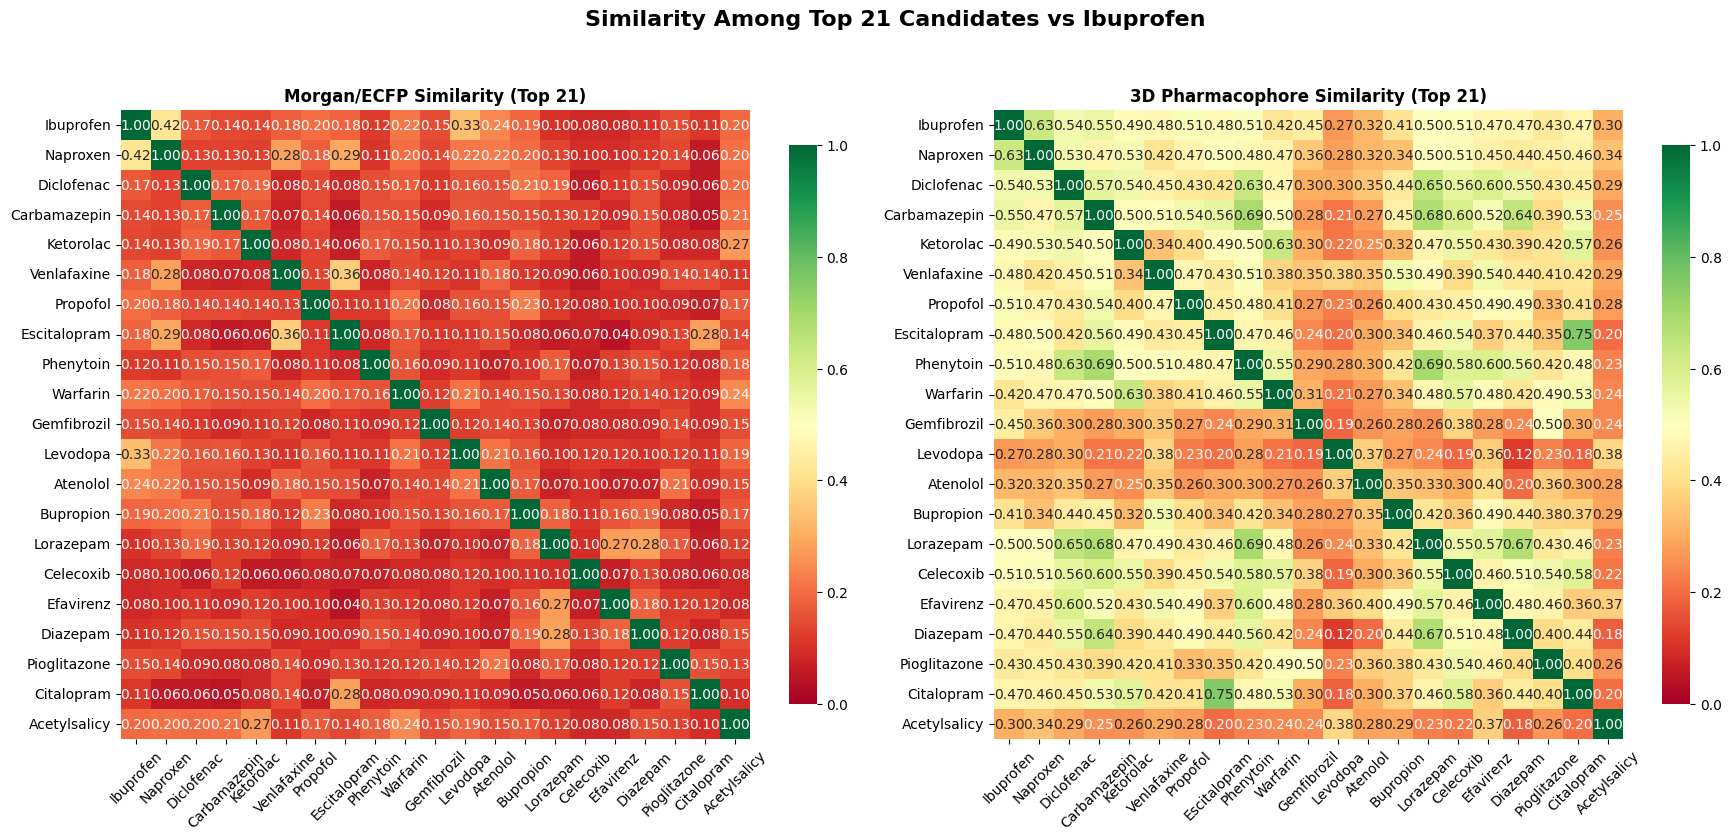

In [14]:
# Create similarity heatmaps for TOP 20 filtered candidates
# (Limiting to top 20 to keep the plot readable)

top_n = 20
top_candidates = passed_df.head(top_n)

candidate_names = [f"{m}_optimized" for m in top_candidates['Molecule_Name'].str.replace('_optimized', '').tolist()]
# Ensure reference is included even if not in top list (for comparison)
if REFERENCE_DRUG not in candidate_names:
    candidate_names = [REFERENCE_DRUG] + candidate_names

if len(candidate_names) > 2:
    # Subset similarity matrices
    valid_names = [n for n in candidate_names if n in sim_pharm_3d.index]
    
    if len(valid_names) > 2:
        subset_3d = sim_pharm_3d.loc[valid_names, valid_names]
        subset_morgan = sim_morgan.loc[valid_names, valid_names]
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        
        # Clean names for display
        display_names = [n.replace('_optimized', '')[:12] for n in valid_names]
        
        # Morgan similarity
        sns.heatmap(subset_morgan, annot=True, fmt='.2f', cmap='RdYlGn', 
                    xticklabels=display_names, yticklabels=display_names,
                    ax=axes[0], vmin=0, vmax=1, square=True, cbar_kws={'shrink': .8})
        axes[0].set_title(f'Morgan/ECFP Similarity (Top {len(valid_names)})', fontsize=12, fontweight='bold')
        axes[0].tick_params(axis='x', rotation=45, labelsize=10)
        axes[0].tick_params(axis='y', rotation=0, labelsize=10)
        
        # 3D Pharmacophore similarity
        sns.heatmap(subset_3d, annot=True, fmt='.2f', cmap='RdYlGn', 
                    xticklabels=display_names, yticklabels=display_names,
                    ax=axes[1], vmin=0, vmax=1, square=True, cbar_kws={'shrink': .8})
        axes[1].set_title(f'3D Pharmacophore Similarity (Top {len(valid_names)})', fontsize=12, fontweight='bold')
        axes[1].tick_params(axis='x', rotation=45, labelsize=10)
        axes[1].tick_params(axis='y', rotation=0, labelsize=10)
        
        plt.suptitle(f'Similarity Among Top {len(valid_names)} Candidates vs {REFERENCE_DRUG.replace("_optimized", "")}', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough valid names found in similarity matrices.")
else:
    print("Not enough candidates to plot heatmap.")

---
## 🔮 3D Pharmacophore Visualization

### Interactive Pharmacophore Explorer

The `visualize_3d_pharmacophore()` function renders molecules with **colored pharmacophore spheres**:

| Feature | Color | Sphere Size |
|---------|-------|-------------|
| **H-Bond Donor** | 🔵 Blue | 1.0 Å |
| **H-Bond Acceptor** | 🔴 Red | 1.0 Å |
| **Aromatic** | 🟣 Purple | 1.5 Å |
| **Hydrophobe** | 🟢 Green | 1.2 Å |
| **Positive Ionizable** | 🟡 Yellow | 1.0 Å |
| **Negative Ionizable** | 🟠 Orange | 1.0 Å |

### Use Cases

1. **Visual validation**: Confirm that high-scoring molecules have features in expected positions
2. **Binding hypothesis**: Identify which features may interact with the target
3. **SAR analysis**: Compare pharmacophore patterns across a chemical series

In [15]:
# Visualize 3D Pharmacophore
import importlib
import src.interactive.pharmacophore_viewer
importlib.reload(src.interactive.pharmacophore_viewer)
from src.interactive import visualize_3d_pharmacophore, create_pharmacophore_explorer

# Define a wrapper to match the expected signature for the widget
# The widget expects func(name, smiles) but our robust function needs helpers too
def viz_wrapper(name, smiles):
    visualize_3d_pharmacophore(
        name, 
        smiles, 
        mol_creator_func=create_mol_with_dft_coords, 
        feature_extractor_func=extract_pharm_features
    )

# 1. Visualize Reference Drug
#viz_wrapper(REFERENCE_DRUG, ref_row['SMILES'])

# 2. Setup Interactive Explorer with the new wrapper
display(create_pharmacophore_explorer(df, viz_wrapper, default_molecule=REFERENCE_DRUG))

---
## 🎛️ Step 5: Interactive Drug Discovery Dashboard

### Drug Screener Dashboard

A comprehensive interactive tool for exploring screening results:

| Tab | Function |
|-----|----------|
| **Rankings** | Sort candidates by any similarity metric |
| **Comparison** | Side-by-side molecular comparison |
| **Properties** | Radar charts of molecular properties |
| **Clustering** | Hierarchical clustering of candidates |

### Adjustable Weights

The dashboard allows real-time adjustment of consensus weights:
- **Morgan weight** (w₁): Chemical similarity emphasis
- **Pharm2D weight** (w₂): Topological pharmacophore emphasis
- **Pharm3D weight** (w₃): 3D spatial similarity emphasis

This enables **sensitivity analysis** — see how rankings change with different weighting schemes.


In [ ]:
# Import and launch the dashboard
from src.interactive.dashboard import DrugScreenerDashboard

# Prepare data dictionary
sim_matrices = {
    'Morgan': sim_morgan,
    'Pharm2D': sim_pharm_2d,
    'Pharm3D': sim_pharm_3d
}

# Launch Drug Screener Dashboard
dashboard = DrugScreenerDashboard(
    molecules=drug_molecules, 
    sim_matrices=sim_matrices,
    df_properties=df
)
dashboard.show()

---
## 📁 Step 6: Data Export & DFT Analysis Collection

### DFTDataCollector

The final cell demonstrates data export using the `DFTDataCollector` class:

1. **Collects molecular properties** from DFT calculations
2. **Extracts atomwise features** (charges, Fukui indices, ESP)
3. **Extracts bond orders** (Mayer, Wiberg)
4. **Exports to multiple formats**:
   - **CSV**: Quick pandas analysis
   - **JSON**: Full hierarchical data with atomic details

### Output Files

| File | Contents | Use Case |
|------|----------|----------|
| `dft_analysis_with_atom_properties.csv` | Molecular-level properties | Quick screening, filtering |
| `dft_full_analysis.json` | Complete atom/bond data | GNN training, detailed analysis |

---

In [17]:
from src.analysis.dft_data_collector import DFTDataCollector

# 1. Collect Data with all features (atomwise + bond orders)
collector = DFTDataCollector(output_dir='./optimized_molecules', save_atom_data=True)
df_results = collector.collect_data()

# 2. Display Preview
if not df_results.empty:
    print(f"✅ Collected results for {len(df_results)} molecules with {len(df_results.columns)} properties!")
    display(df_results.head())
    
    # 3. Save molecular-level CSV (for quick pandas analysis)
    csv_path = "dft_analysis_with_atom_properties.csv"
    df_results.to_csv(csv_path, index=False)
    print(f"\n📦 Saved CSV to '{csv_path}'")
    
    # 4. Save COMPREHENSIVE JSON with ALL data (molecular + atomic + bond orders)
    json_path = collector.save_full_analysis_json(df_results, 'dft_full_analysis.json')
    
    # 5. Show what's in the JSON
    import json as json_module
    with open('dft_full_analysis.json', 'r') as f:
        full_data = json_module.load(f)
    
    sample_mol = list(full_data.keys())[0]
    sample = full_data[sample_mol]
    

Found 166 wavefunction files in optimized_molecules
✅ Collected results for 166 molecules with 87 properties!


,Molecule_Name,SMILES,Num_Atoms,Total_Energy_Ha,HOMO_eV,LUMO_eV,Gap_eV,Dipole_Moment_Debye,Polarizability_au3,Volume_A3,...,Muegge_Pass,LeadLike_Pass,BBB_Penetration,hERG_Risk,Solubility,CYP_Inhibition,Aggregator_Risk,PAINS_Alerts,Oral_Bioavailability,File_Path
0,Midazolam_optimized,Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2,36,-1399.886146,-4.564403,0.691601,5.256005,1.848954,2495.056841,328.247481,...,True,False,Moderate,Moderate,Moderate,Moderate,High,None,Yes,optimized_molecules/Midazolam_optimized/wavefu...
1,Metformin_optimized,CN(C)C(=N)NC(=N)N,20,-426.794167,-4.160025,2.952789,7.112814,2.810917,510.098426,143.958771,...,False,False,Moderate,Moderate,Good,Low,Low,None,Yes,optimized_molecules/Metformin_optimized/wavefu...
2,Empagliflozin_optimized,OC[C@H]1OC(c2ccc(Cl)c(Cc3ccc(OC4CCCC4)cc3)c2)[...,60,-1819.490353,-3.666707,2.365831,6.032538,2.149200,8216.052198,488.716767,...,True,False,Moderate,Low,Good,Moderate,Low,None,Yes,optimized_molecules/Empagliflozin_optimized/wa...
3,Valacyclovir_optimized,CC(C)C(N)C(=O)OCCOCn1cnc2c1nc(N)[nH]c2=O,43,-1121.103161,-3.709735,2.147756,5.857491,6.872420,3958.361688,338.838315,...,False,True,Low,Moderate,Good,Low,Low,None,No,optimized_molecules/Valacyclovir_optimized/wav...
4,Fluoxetine_optimized,CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1,40,-1073.006199,-3.970082,2.483460,6.453542,3.700006,3568.516527,330.219720,...,True,False,Moderate,High,Moderate,Moderate,Medium,None,Yes,optimized_molecules/Fluoxetine_optimized/wavef...



📦 Saved CSV to 'dft_analysis_with_atom_properties.csv'
💾 Saved comprehensive analysis to 'dft_full_analysis.json'
   └─ 166 molecules
   └─ Molecular properties: 75 columns
   └─ Atom properties: 11 arrays
   └─ Bond orders: ['mayer', 'wiberg']




## 🎯 Summary

This notebook demonstrates a complete **virtual screening workflow**:

1. ✅ **Data preparation** with RDKit molecule parsing
2. ✅ **Drug-likeness filtering** (Lipinski, Veber, Lead-like, QED)
3. ✅ **Multi-metric similarity** (Morgan, 2D/3D Pharmacophore)
4. ✅ **Consensus scoring** for robust hit prioritization
5. ✅ **Interactive visualization** (3D structures, pharmacophores)
6. ✅ **Data export** for downstream analysis

### Skills Demonstrated

| Skill | Implementation |
|-------|---------------|
| **Cheminformatics** | RDKit molecular processing, fingerprints |
| **Drug Discovery** | Pharmacophore modeling, ADMET filtering |
| **Data Science** | Pandas, similarity matrices, consensus scoring |
| **Visualization** | Matplotlib, Seaborn, py3Dmol |
| **Software Engineering** | Modular code, custom classes, widgets |
| **Quantum Chemistry** | DFT feature extraction and integration |